In [484]:
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
import seaborn as sns
import sys
from utils import *

In [485]:
slot = 3  # length of the interval in hours for resampling
look_back = int(7*24/slot)

test_size = 0.2
time_range = (pd.Timestamp(2018, 1, 1), pd.Timestamp(2021, 7, 1))

In [486]:
dataset = select_data('compute_haswell.csv', time_range)
plot_rsrc(dataset, 'compute_haswell')

In [487]:
dataset.shape

(30752, 12)

## Step 1. Resample by a time slot

Counting the number of nodes assigned to Chameleon users within a fixed time interval.

In [488]:
dataset = resample_sum(dataset, slot)
# dataset = get_roll_avg(dataset, rw)
dataset.dropna(inplace=True)
plot_rsrc(dataset, 'compute_haswell')
dataset.set_index(['start_on'], inplace=True)

In [489]:
dataset.shape

(9453, 1)

In [490]:
dataset = dataset.astype(float)
actual_train, actual_test = train_test_split(dataset, test_size=test_size, shuffle=False)

## Step 2. Smooth data

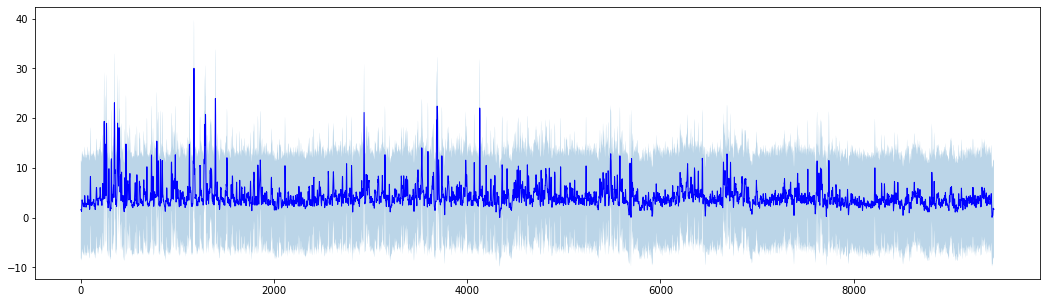

In [491]:
smoother = lowess_smoother(dataset)
# generate intervals
low, up = smoother.get_intervals('sigma_interval')
# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))
plt.plot(smoother.smooth_data.squeeze(), linewidth=1, color='blue')
plt.fill_between(range(len(smoother.data.squeeze())), low[0], up[0], alpha=0.3)
plt.show()

In [492]:
dataset['node_cnt'] = smoother.smooth_data.squeeze()

## Step 3. Build LSTM Model

In [493]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp
import math

In [494]:
# fix random seed for reproducibility
np.random.seed(42)

# data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split training and testing dataset
train, test = train_test_split(dataset, test_size=test_size, shuffle=False)

In [495]:
def create_dataset(ds, lb=1):
    """
    :param ds: a numpy array that you want to convert into a dataset
    :param lb: the number of previous time steps to use as input variables to predict the next time period
    :return: x, y for training LSTM
    """
    data_x, data_y = [], []
    for i in range(len(ds) - lb - 1):
        a = ds[i:(i + lb), 0]
        data_x.append(a)
        data_y.append(ds[i + lb, 0])
    return np.array(data_x), np.array(data_y)

In [496]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [497]:
def loss_function(y_true, y_pred):
    # difference = tf.abs(y_pred - y_true)
    
    abs_diff = tf.abs(y_pred - y_true)
    # difference = tfp.stats.percentile(abs_diff, 90)
    return tf.reduce_mean(difference, axis=-1)
    return difference

In [498]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), activation='tanh'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1, validation_split=0.2, callbacks=[es])

Epoch 1/100
6004/6004 [==============================] - 10s 2ms/step - loss: 0.0300 - val_loss: 0.0142
Epoch 2/100
6004/6004 [==============================] - 9s 2ms/step - loss: 0.0188 - val_loss: 0.0111
Epoch 3/100
6004/6004 [==============================] - 8s 1ms/step - loss: 0.0162 - val_loss: 0.0120
Epoch 4/100
6004/6004 [==============================] - 8s 1ms/step - loss: 0.0148 - val_loss: 0.0090
Epoch 5/100
6004/6004 [==============================] - 8s 1ms/step - loss: 0.0141 - val_loss: 0.0147
Epoch 6/100
6004/6004 [==============================] - 8s 1ms/step - loss: 0.0132 - val_loss: 0.0087
Epoch 7/100
6004/6004 [==============================] - 8s 1ms/step - loss: 0.0132 - val_loss: 0.0188
Epoch 8/100
6004/6004 [==============================] - 9s 2ms/step - loss: 0.0125 - val_loss: 0.0108
Epoch 9/100
6004/6004 [==============================] - 10s 2ms/step - loss: 0.0124 - val_loss: 0.0100
Epoch 10/100
6004/6004 [==============================] - 10s 2ms/step 

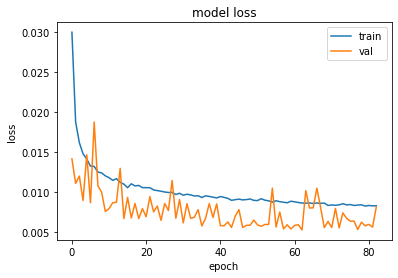

In [499]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [500]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.42 RMSE
Test Score: 0.25 RMSE


In [501]:
df = pd.DataFrame([])
df['start_on'] = actual_test.index[look_back:-1]
df.set_index(['start_on'], inplace=True)
df['forecast'] = testPredict.squeeze()
df['smooth'] = testY.squeeze()
df['actual'] = actual_test['node_cnt'].to_list()[look_back:-1]
plot_trace(df, ['forecast', 'actual', 'smooth'])

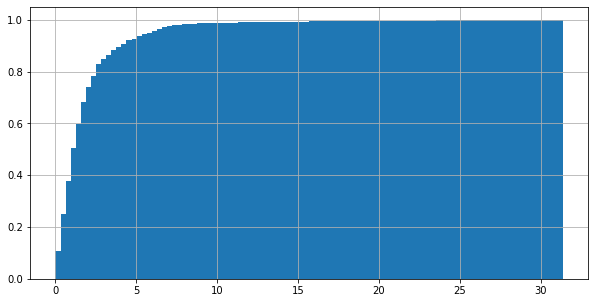

In [502]:
df['AE'] = abs(df['forecast'] - df['actual'])
df['AE'].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))
plt.show()

In [503]:
np.quantile(df['AE'], 0.95)

6.038809740543365

array([[<AxesSubplot:title={'center':'difference'}>]], dtype=object)

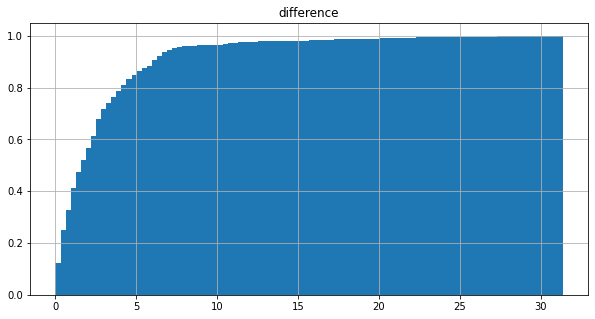

In [504]:
temp = (df['actual']-df['forecast']).to_frame()
temp.columns = ['difference']
temp[temp['difference'] > 0].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))

In [505]:
100*temp[temp['difference'] > 0].shape[0]/df.shape[0]

37.24100327153762